# Isolet dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

%load_ext autoreload
%autoreload 1
%aimport zero_shot_active_learning

data = pd.read_csv("../../../Datasets/Isolet/isolet1+2+3+4.data", header=None).dropna()
data.append(pd.read_csv("../../../Datasets/Isolet/isolet5.data", header=None).dropna())
y = data.pop(617).values.astype(int)
X = data.values
X = normalize(X, norm='max',axis=0)
unique, count = np.unique(y, return_counts=True)
print(unique, count/len(y), X.shape)

/home/lasa/.conda/envs/topo/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26] [0.038 0.038 0.038 0.038 0.038 0.038 0.038 0.038 0.038 0.038 0.038 0.038
 0.038 0.038 0.038 0.038 0.038 0.038 0.038 0.038 0.038 0.038 0.038 0.038
 0.038 0.038] (6238, 617)


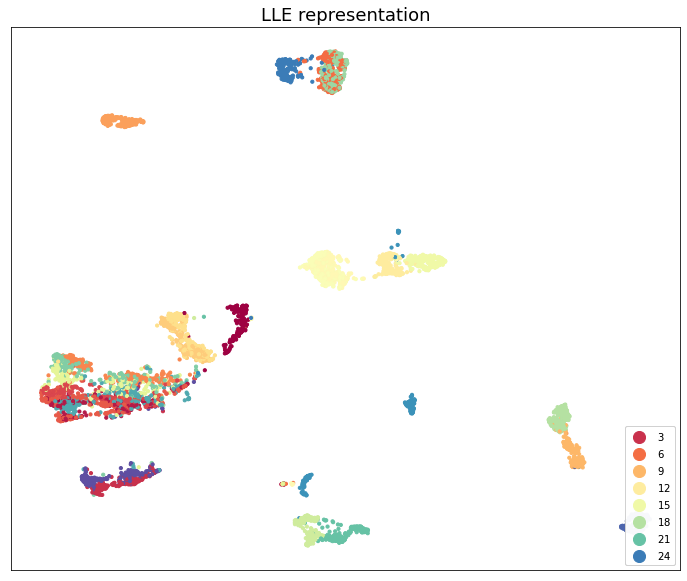

In [4]:
import umap
from sklearn.manifold import LocallyLinearEmbedding
import matplotlib.pyplot as plt

#embedding = LocallyLinearEmbedding(n_components=2)
embedding = umap.UMAP(random_state=2020)
X_transformed = embedding.fit_transform(X)

fig, ax = plt.subplots(figsize=(12, 10))
scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap="Spectral", s=10)
plt.setp(ax, xticks=[], yticks=[])
plt.title("LLE representation", fontsize=18)
legend2 = ax.legend(*scatter.legend_elements(), loc="lower right", prop={'size': 10} , markerscale=2.)
ax.add_artist(legend2)
plt.show()

## Save 20 random split pre-computed data

In [3]:
from sklearn.neighbors import NearestNeighbors
from data_gen import *

ids_train = Datasets.load_obj('isolet_train')
ids_test = Datasets.load_obj('isolet_test')
dists_ = []
idxs_ = []
density_ = []
for i in range(20):
    num_pts = X[ids_train[i],:].shape[0]
    nbrs = NearestNeighbors(n_neighbors=int(num_pts / 10), n_jobs=-1).fit(X[ids_train[i],:])
    dist_, idx_ = nbrs.kneighbors()
    dists_.append(dist_)
    idxs_.append(idx_)
    density_.append(1/np.sqrt(np.mean(np.square(dist_), axis=1)))

In [9]:
from data_gen import *
Datasets.save_obj(ids_train, 'isolet_train')
Datasets.save_obj(ids_test, 'isolet_test')

###### split  0  ######
max occurence for distance:  10.683047212040746
min :  3.3657751624615018  max :  24.101808513943446


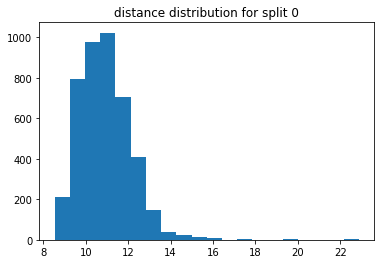

max occurence for density:  0.08754065971525926
min :  0.04354327758042755  max :  0.11687224780514706


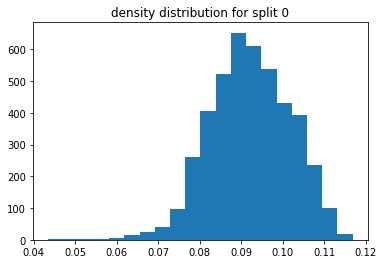

###### split  1  ######
max occurence for distance:  10.65487880300499
min :  3.3657751624615018  max :  24.09120538841191


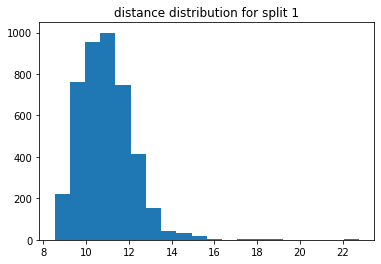

max occurence for density:  0.08774691009789115
min :  0.04373758112747456  max :  0.11708646274483556


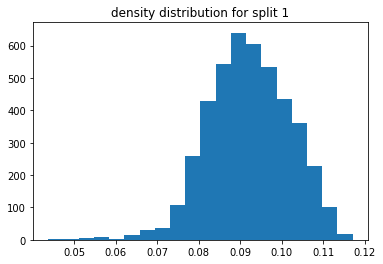

###### split  2  ######
max occurence for distance:  10.104965024696263
min :  3.3657751624615018  max :  25.569803633088828


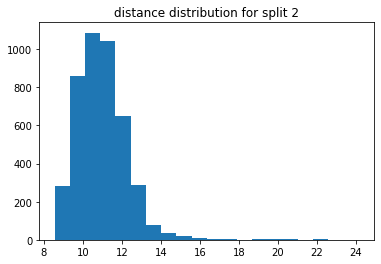

max occurence for density:  0.09028426331665959
min :  0.04121808665545082  max :  0.11670451228807971


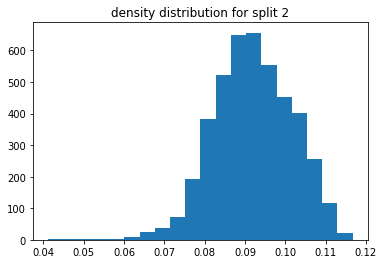

###### split  3  ######
max occurence for distance:  10.112131361569778
min :  4.014984447775349  max :  25.60621495641396


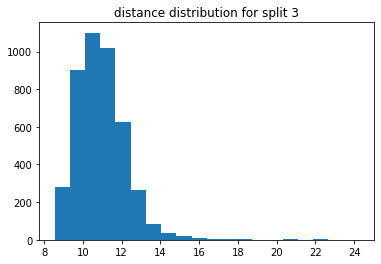

max occurence for density:  0.08647189878373553
min :  0.04108390243961274  max :  0.11673056301315073


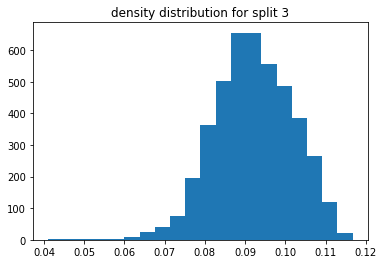

###### split  4  ######
max occurence for distance:  10.061432878300689
min :  4.014984447775349  max :  25.545764312974974


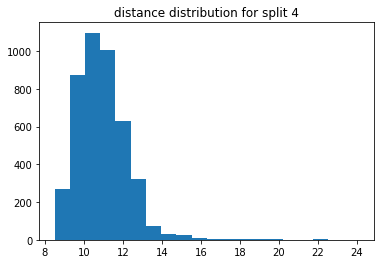

max occurence for density:  0.09071743903035884
min :  0.041291364977657535  max :  0.11733147890489029


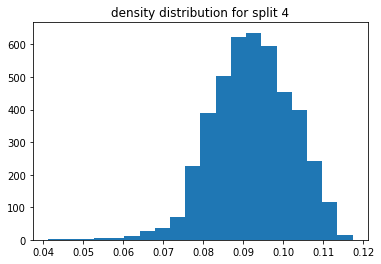

In [3]:
import matplotlib.pyplot as plt

for i in range(5):
    print('###### split ',i,' ######')
    bin, h, _ = plt.hist(np.average(dists_[i], axis=1),bins=20)
    print('max occurence for distance: ', h[np.argmax(bin)])
    print('min : ', np.min(dists_[i]), ' max : ', np.max(dists_[i]))
    plt.title('distance distribution for split '+str(i))
    plt.show()
    bin, h, _ = plt.hist(density_[i], bins=20)
    print('max occurence for density: ', h[np.argmax(bin)])
    print('min : ', np.min(density_[i]), ' max : ', np.max(density_[i]))
    plt.title('density distribution for split '+str(i))
    plt.show()

# Sample importance with loo loss

In [5]:
import data_gen
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

loo = LeaveOneOut()
scores = []
for train_index, test_index in loo.split(X):
    X_train, y_train = X[train_index], y[train_index]
    clf = SGDClassifier(random_state=2020, n_jobs=-1)
    scores.append(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))
Datasets.save_obj(scores, 'isolet_scores')

KeyboardInterrupt: 

# Classif results

# Bmeans

In [4]:
from zero_shot_active_learning import BMeans
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import numpy as np

for k in [10, 50, 100]:
    acc_r = []
    acc_b = []
    acc_s = []
    for r in range(20):
        m = BMeans(n_clusters=k, verbose=False)
        m.fit(X[ids_train[r],:], y[ids_train[r]])
        train_x = X[ids_train[r],:][m.labels_ != -1,]
        train_y = m.labels_[m.labels_ != -1]
        
        # Bmeans set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(train_x, train_y)
        acc_b.append(clf.score(X[ids_test[r],:], y[ids_test[r]]))
        
        # Seed set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(m.seed[0], m.seed[1])
        acc_s.append(clf.score(X[ids_test[r],:], y[ids_test[r]]))
        
        # Random set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(X[ids_train[r],:][:k,], y[ids_train[r]][:k])
        acc_r.append((clf.score(X[ids_test[r],:], y[ids_test[r]])))
    print('## -- Budget k = ', k)
    print('BMeans : mean=%.5f, std=%.5f' % (np.mean(acc_b), np.std(acc_b)))
    print('Seed set : mean=%.5f, std=%.5f' % (np.mean(acc_s), np.std(acc_s)))
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

## -- Budget k =  10
BMeans : mean=0.32134, std=0.01044
Seed set : mean=0.19744, std=0.03516
Random : mean=0.15280, std=0.03321
## -- Budget k =  50
BMeans : mean=0.64001, std=0.01338
Seed set : mean=0.49049, std=0.02805
Random : mean=0.36408, std=0.03977
## -- Budget k =  100
BMeans : mean=0.71776, std=0.01416
Seed set : mean=0.62810, std=0.03973
Random : mean=0.54447, std=0.03717


In [4]:
from zero_shot_active_learning import BMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

for k in [10, 50, 100]:
    acc_r = []
    acc_b = []
    acc_s = []
    for r in range(20):
        m = BMeans(n_clusters=k, verbose=False)
        m.fit(X[ids_train[r],:], y[ids_train[r]])
        train_x = X[ids_train[r],:][m.labels_ != -1,]
        train_y = m.labels_[m.labels_ != -1]
        
        # Bmeans set classif
        clf = RandomForestClassifier(random_state=2020, n_jobs=-1)
        clf.fit(train_x, train_y)
        acc_b.append(clf.score(X[ids_test[r],:], y[ids_test[r]]))
        
        # Seed set classif
        clf = RandomForestClassifier(random_state=2020, n_jobs=-1)
        clf.fit(m.seed[0], m.seed[1])
        acc_s.append(clf.score(X[ids_test[r],:], y[ids_test[r]]))
        
        # Random set classif
        clf = RandomForestClassifier(random_state=2020, n_jobs=-1)
        clf.fit(X[ids_train[r],:][:k,], y[ids_train[r]][:k])
        acc_r.append((clf.score(X[ids_test[r],:], y[ids_test[r]])))
    print('## -- Budget k = ', k)
    print('BMeans : mean=%.5f, std=%.5f' % (np.mean(acc_b), np.std(acc_b)))
    print('Seed set : mean=%.5f, std=%.5f' % (np.mean(acc_s), np.std(acc_s)))
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

## -- Budget k =  10
BMeans : mean=0.32313, std=0.01112
Seed set : mean=0.22855, std=0.01300
Random : mean=0.14121, std=0.02882
## -- Budget k =  50
BMeans : mean=0.65008, std=0.01933
Seed set : mean=0.44856, std=0.03525
Random : mean=0.32775, std=0.02793
## -- Budget k =  100
BMeans : mean=0.73558, std=0.01835
Seed set : mean=0.64292, std=0.02391
Random : mean=0.52059, std=0.03771


# Intersection

In [4]:
from zero_shot_active_learning import BMeans
from zero_shot_active_learning import TCAL 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model
import numpy as np

for k in [10, 50, 100]:
    acc_tcal = []
    acc_bmeans = []
    for i in range(20):
        b = BMeans(n_clusters=k, verbose=False)
        b.fit(X[ids_train[i],:], y[ids_train[i]])
        t = TCAL(rad=23, y=y[ids_train[i]], m=.09, n_clusters=k, 
                 density=density_[i], dist=dists_[i], idx=idxs_[i])
        _, train_y = t.fit(X[ids_train[i],:])
        acc_tcal.append(accuracy_score(y[ids_train[i]][t.labels_ != -1], train_y))
        acc_bmeans.append(accuracy_score(y[ids_train[i]][t.labels_ != -1], b.labels_[t.labels_ != -1]))
    print('## -- Budget k = ', k)
    print('BMeans accuracy on intersection: mean=%.5f, std=%.5f' % (np.mean(acc_bmeans), np.std(acc_bmeans)))
    print('TCAL accuracy on intersection : mean=%.5f, std=%.5f' % (np.mean(acc_tcal), np.std(acc_tcal)))

## -- Budget k =  10
BMeans accuracy on intersection: mean=0.41496, std=0.06045
TCAL accuracy on intersection : mean=0.75273, std=0.05354
## -- Budget k =  50
BMeans accuracy on intersection: mean=0.83108, std=0.02230
TCAL accuracy on intersection : mean=0.79267, std=0.03362
## -- Budget k =  100
BMeans accuracy on intersection: mean=0.86088, std=0.01014
TCAL accuracy on intersection : mean=0.79384, std=0.02792


In [17]:
from zero_shot_active_learning import BMeans
from zero_shot_active_learning import TCAL 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model
import numpy as np

for k in [10, 50, 100]:
    acc_tcal = []
    size = []
    acc_bmeans = []
    for i in range(20):
        b = BMeans(n_clusters=k, verbose=False)
        b.fit(X[ids_train[i],:], y[ids_train[i]])
        t = TCAL(rad=23, y=y[ids_train[i]], m=.09, n_clusters=k, bais=0.99,
                 density=density_[i], dist=dists_[i], idx=idxs_[i])
        _, train_y = t.fit(X[ids_train[i],:])
        size.append(len(train_y))
        acc_tcal.append(accuracy_score(y[ids_train[i]][t.labels_ != -1], train_y))
        acc_bmeans.append(accuracy_score(y[ids_train[i]][t.labels_ != -1], b.labels_[t.labels_ != -1]))
    print('## -- Budget k = ', k)
    print('Average size: ', np.mean(size))
    print('BMeans accuracy on intersection: mean=%.5f, std=%.5f' % (np.mean(acc_bmeans), np.std(acc_bmeans)))
    print('TCAL accuracy on intersection : mean=%.5f, std=%.5f' % (np.mean(acc_tcal), np.std(acc_tcal)))

## -- Budget k =  10
Average size:  340.25
BMeans accuracy on intersection: mean=0.40502, std=0.14706
TCAL accuracy on intersection : mean=0.93573, std=0.03631
## -- Budget k =  50
Average size:  652.95
BMeans accuracy on intersection: mean=0.88635, std=0.01998
TCAL accuracy on intersection : mean=0.89947, std=0.02363
## -- Budget k =  100
Average size:  845.95
BMeans accuracy on intersection: mean=0.89156, std=0.01691
TCAL accuracy on intersection : mean=0.88509, std=0.01988


In [21]:
from zero_shot_active_learning import BMeans
from zero_shot_active_learning import TCAL 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model
import numpy as np

for k in [10, 50, 100]:
    acc_tcal = []
    size = []
    acc_bmeans = []
    for i in range(20):
        b = BMeans(n_clusters=k, verbose=False)
        b.fit(X[ids_train[i],:], y[ids_train[i]])
        t = TCAL(rad=24, y=y[ids_train[i]], m=.09, n_clusters=k, bais=0.99,
                 density=density_[i], dist=dists_[i], idx=idxs_[i])
        _, train_y = t.fit(X[ids_train[i],:])
        size.append(len(train_y))
        acc_tcal.append(accuracy_score(y[ids_train[i]][t.labels_ != -1], train_y))
        acc_bmeans.append(accuracy_score(y[ids_train[i]][t.labels_ != -1], b.labels_[t.labels_ != -1]))
    print('## -- Budget k = ', k)
    print('Average size: ', np.mean(size))
    print('BMeans accuracy on intersection: mean=%.5f, std=%.5f' % (np.mean(acc_bmeans), np.std(acc_bmeans)))
    print('TCAL accuracy on intersection : mean=%.5f, std=%.5f' % (np.mean(acc_tcal), np.std(acc_tcal)))

## -- Budget k =  10
Average size:  368.35
BMeans accuracy on intersection: mean=0.43139, std=0.12649
TCAL accuracy on intersection : mean=0.92048, std=0.03837
## -- Budget k =  50
Average size:  799.7
BMeans accuracy on intersection: mean=0.89148, std=0.01400
TCAL accuracy on intersection : mean=0.90488, std=0.01802
## -- Budget k =  100
Average size:  1058.85
BMeans accuracy on intersection: mean=0.90401, std=0.01573
TCAL accuracy on intersection : mean=0.89622, std=0.01483


# TCAL

## -- tau estimated

In [12]:
from zero_shot_active_learning import TCAL 
from sklearn import linear_model
import numpy as np

for k in [10]:
    acc_r = []
    acc_t = []
    acc_p = []
    acc_s = []

    for i in range(20):
        m = TCAL(density=density_[i], dist=dists_[i], idx=idxs_[i],
                            y=y[ids_train[i]], m=.09, rad=23, n_clusters=k)
        train_x, train_y = m.fit(X[ids_train[i],:])

        # TCAL set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(train_x, train_y)
        acc_t.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))
        
        # TCAL+PROP set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(X[ids_train[i],:], m.model.predict(X[ids_train[i],:]))
        acc_p.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))
        
        # Seed set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(m.seed[0], m.seed[1])
        acc_s.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))

        # Random set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(X[ids_train[i],:][:k,], y[ids_train[i]][:k])
        acc_r.append((clf.score(X[ids_test[i],:], y[ids_test[i]])))
    print('## -- Budget k = ', k)
    print('TCAL : mean=%.5f, std=%.5f' % (np.mean(acc_t), np.std(acc_t)))
    print('TCAL+PROP : mean=%.5f, std=%.5f' % (np.mean(acc_p), np.std(acc_p)))
    print('Seed set : mean=%.5f, std=%.5f' % (np.mean(acc_s), np.std(acc_s)))
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normal

## -- Budget k =  10
TCAL : mean=0.32815, std=0.03078
TCAL+PROP : mean=0.33486, std=0.02930
Seed set : mean=0.21202, std=0.02464
Random : mean=0.15280, std=0.03321


In [6]:
from zero_shot_active_learning import TCAL 
from sklearn.ensemble import RandomForestClassifier
import numpy as np

for k in [10, 50, 100]:
    acc_r = []
    acc_t = []
    acc_p = []

    for i in range(20):
        m = TCAL(density=density_[i], dist=dists_[i], idx=idxs_[i],
                            y=y[ids_train[i]], m=.09, rad=23, n_clusters=k)
        train_x, train_y = m.fit(X[ids_train[i],:])

        # TCAL set classif
        clf = RandomForestClassifier(random_state=2020, n_jobs=-1)
        clf.fit(train_x, train_y)
        acc_t.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))
        
        # TCAL+PROP set classif
        acc_p.append(m.model.score(X[ids_test[i],:], y[ids_test[i]]))

        # Random set classif
        clf = RandomForestClassifier(random_state=2020, n_jobs=-1)
        clf.fit(X[ids_train[i],:][:k,], y[ids_train[i]][:k])
        acc_r.append((clf.score(X[ids_test[i],:], y[ids_test[i]])))
    print('## -- Budget k = ', k)
    print('TCAL : mean=%.5f, std=%.5f' % (np.mean(acc_t), np.std(acc_t)))
    print('TCAL+PROP : mean=%.5f, std=%.5f' % (np.mean(acc_p), np.std(acc_p)))
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normal

## -- Budget k =  10
TCAL : mean=0.33603, std=0.03177
TCAL+PROP : mean=0.33734, std=0.03171
Random : mean=0.14121, std=0.02882
## -- Budget k =  50
TCAL : mean=0.59193, std=0.02487
TCAL+PROP : mean=0.58304, std=0.02448
Random : mean=0.32775, std=0.02793
## -- Budget k =  100
TCAL : mean=0.67142, std=0.02082
TCAL+PROP : mean=0.65833, std=0.01849
Random : mean=0.52059, std=0.03771


In [30]:
from sklearn.metrics import accuracy_score 
from sklearn import linear_model
import metrics

for rad in [23]:
    for m in [0.09]:
        for b in [1]:
            acc_r = []
            acc_o = []
            print('########### run r=', rad,' m=' , m,' bais=', b, ' ###########')
            for i in range(1):
                print(('########### split ',i,' ###########'))
                mnist_clst = TCAL(density=density_[i], dist=dists_[i], idx=idxs_[i], 
                                  balanced=False, y=y[ids_train[i]], m = m, bais=b, rad=rad, n_clusters=10)
                if mnist_clst.fit(X[ids_train[i],:]):
                    continue
                unique, counts = np.unique(mnist_clst.labels_, return_counts=True)
                print(unique)
                print(counts)
                print('Isolated points : ', np.sum(counts ==1))
                for c in unique[counts > 4]:
                    msq = np.isin(mnist_clst.labels_, [c])
                    acc = np.round(metrics.acc(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    nmi = np.round(metrics.nmi(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    ari = np.round(metrics.ari(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    print('** class ',mnist_clst.labels_[msq][0],' : acc=%.5f, nmi=%.5f, ari=%.5f' % (acc, nmi, ari))
                train_x = X[ids_train[i],:][mnist_clst.labels_ != -1,]
                train_y = mnist_clst.labels_[mnist_clst.labels_ != -1]
                if len(np.unique(train_y)) > 1:
                    clf = linear_model.SGDClassifier(random_state=2020)
                    clf.fit(train_x, train_y)
                    acc_o.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))
                else:
                    acc_o.append(accuracy_score(y[ids_test[i]], train_y[0]*np.ones(len(ids_test[i]))))
                if len(np.unique(y[ids_train[i]][:mnist_clst.n_clusters])) > 1:
                    clf = linear_model.SGDClassifier(random_state=2020)
                    clf.fit(X[ids_train[i],:][:mnist_clst.n_clusters,], y[ids_train[i]][:mnist_clst.n_clusters])
                    acc_r.append((clf.score(X[ids_test[i],:], y[ids_test[i]])))
                else:
                    acc_r.append(accuracy_score(y[ids_test[i]], y[ids_train[i]][0]*np.ones(len(ids_test[i]))))
            print('Ours : mean=%.5f, std=%.5f' % (np.mean(acc_o), np.std(acc_o)))
            print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

########### run r= 23  m= 0.09  bais= 1  ###########
('########### split ', 0, ' ###########')
[2281 3909 2205 ... 2465 2463    0] [224 145 121 ...   1   1   1]
[3415 2281 1457 3909 2949 2205 1848 1439  579 3884  880 4209 2425  874
 3184 3125 1387  989 1614 3684 3572 1606 2286 2620  644  950 3864 2617
 2736 3922 3714 4126 3645 1170  560 2088 2997 1792 2407  969 3434 2509
 4299 2820  358 2053  207 3787 4001 2810 1747 3432 3298 2311 1490 3351
 3384 2696 3564  553  308 3878 2195 1257 1133 2065 2873  285 2020 2937
 1665 3800 2345  843 4130  161  218 4000 1256 1750 2531 3540  117 1175
 1060 4017 3205  473 4260 1254 1451 3794 4235 2747 1396  350 3294 2857
 3620 2475 3710 3402 1382 2742 2864  664 4220 4050  144 3352 2792 2177
  268 1768 2692 1925  462 2575  356 2648 3244 1837 3375 1203 1375 3082
 4018  274 1720  937 2128 2097 2362 1362  341 2731 3105  156 3631 3693
 3132 2175 2886 1741 3287 1964 2800 3149 2958 1853 1779 3014 2710 3122
 1800 2064 2292 2852 3491 4245  784 1085 4081 1248  957 37

## -- Budget = 10, tau=0

In [4]:
from sklearn.metrics import accuracy_score
from fuzzy_clustering import Fuzzy_ToMATo 
from sklearn import linear_model
import metrics

for rad in [23]:
    for m in [0.09]:
        for b in [1]:
            acc_r = []
            acc_o = []
            print('########### run r=', rad,' m=' , m,' bais=', b, ' ###########')
            for i in range(20):
                print(('########### split ',i,' ###########'))
                mnist_clst = Fuzzy_ToMATo(density=density_[i], dist=dists_[i], idx=idxs_[i], tau=0, y=y[ids_train[i]], m = m, bais=b, rad=rad, n_clusters=10)
                if mnist_clst.fit(X[ids_train[i],:]):
                    continue
                unique, counts = np.unique(mnist_clst.labels_, return_counts=True)
                print(unique)
                print(counts)
                print('Isolated points : ', np.sum(counts ==1))
                for c in unique[counts > 4]:
                    msq = np.isin(mnist_clst.labels_, [c])
                    acc = np.round(metrics.acc(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    nmi = np.round(metrics.nmi(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    ari = np.round(metrics.ari(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    print('** class ',mnist_clst.labels_[msq][0],' : acc=%.5f, nmi=%.5f, ari=%.5f' % (acc, nmi, ari))
                train_x = X[ids_train[i],:][mnist_clst.labels_ != -1,]
                train_y = mnist_clst.labels_[mnist_clst.labels_ != -1]
                if len(np.unique(train_y)) > 1:
                    clf = linear_model.SGDClassifier(random_state=2020)
                    clf.fit(train_x, train_y)
                    acc_o.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))
                else:
                    acc_o.append(accuracy_score(y[ids_test[i]], train_y[0]*np.ones(len(ids_test[i]))))
                if len(np.unique(y[ids_train[i]][:mnist_clst.n_clusters])) > 1:
                    clf = linear_model.SGDClassifier(random_state=2020)
                    clf.fit(X[ids_train[i],:][:mnist_clst.n_clusters,], y[ids_train[i]][:mnist_clst.n_clusters])
                    acc_r.append((clf.score(X[ids_test[i],:], y[ids_test[i]])))
                else:
                    acc_r.append(accuracy_score(y[ids_test[i]], y[ids_train[i]][0]*np.ones(len(ids_test[i]))))
            print(acc_o)
            print('Ours : mean=%.5f, std=%.5f' % (np.mean(acc_o), np.std(acc_o)))
            print(acc_r)
            print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

########### run r= 23  m= 0.09  bais= 1  ###########
('########### split ', 0, ' ###########')
Computing underlying neighborhood graph :  0.1538328780000029 seconds
Sorting points by density :  0.004075763999992432 seconds
MERGES :  0
B_max :  1440
main clusters :  10
ERROR: not all classes !!!
[-1  1  3  6  9 15 17 18 21 24 25]
[3896   47   47   47   47   47   47   47   47   47   47]
Isolated points :  0
** class  -1  : acc=0.04697, nmi=0.00000, ari=0.00000
** class  1  : acc=0.93617, nmi=-0.00000, ari=0.00000
** class  3  : acc=0.85106, nmi=-0.00000, ari=0.00000
** class  6  : acc=0.51064, nmi=-0.00000, ari=0.00000
** class  9  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  15  : acc=0.61702, nmi=-0.00000, ari=0.00000
** class  17  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  18  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  21  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  24  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  25  : acc=1.00000, nmi=1.00000, ari=1.000

('########### split ', 9, ' ###########')
Computing underlying neighborhood graph :  0.13369717600002673 seconds
Sorting points by density :  0.0034815749999950185 seconds
MERGES :  0
B_max :  1422
main clusters :  10
ERROR: not all classes !!!
[-1  3  6  8 11 12 15 18 24 25]
[4033   37   37   37   37   37   37   37   37   37]
Isolated points :  0
** class  -1  : acc=0.04438, nmi=-0.00000, ari=0.00000
** class  3  : acc=0.83784, nmi=-0.00000, ari=0.00000
** class  6  : acc=0.56757, nmi=-0.00000, ari=0.00000
** class  8  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  11  : acc=0.51351, nmi=-0.00000, ari=0.00000
** class  12  : acc=0.48649, nmi=-0.00000, ari=0.00000
** class  15  : acc=0.83784, nmi=-0.00000, ari=0.00000
** class  18  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  24  : acc=0.94595, nmi=0.00000, ari=0.00000
** class  25  : acc=1.00000, nmi=1.00000, ari=1.00000
('########### split ', 10, ' ###########')
Computing underlying neighborhood graph :  0.12799854799999366 s

MERGES :  0
B_max :  1417
main clusters :  10
ERROR: not all classes !!!
[-1  3  6  9 11 15 17 18 21 24 25]
[3896   47   47   47   47   47   47   47   47   47   47]
Isolated points :  0
** class  -1  : acc=0.04748, nmi=-0.00000, ari=0.00000
** class  3  : acc=0.76596, nmi=0.00000, ari=0.00000
** class  6  : acc=0.46809, nmi=-0.00000, ari=0.00000
** class  9  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  11  : acc=0.78723, nmi=-0.00000, ari=0.00000
** class  15  : acc=0.70213, nmi=-0.00000, ari=0.00000
** class  17  : acc=0.97872, nmi=0.00000, ari=0.00000
** class  18  : acc=0.95745, nmi=0.00000, ari=0.00000
** class  21  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  24  : acc=0.97872, nmi=0.00000, ari=0.00000
** class  25  : acc=1.00000, nmi=1.00000, ari=1.00000
('########### split ', 19, ' ###########')
Computing underlying neighborhood graph :  0.12446338899999887 seconds
Sorting points by density :  0.003773211000009269 seconds
MERGES :  0
B_max :  1424
main clusters :  10
E

## -- Budget = 10 with tau

In [5]:
from sklearn.metrics import accuracy_score
from zero_shot_active_learning import TCAL 
from sklearn import linear_model
import metrics

acc_r = []
acc_o = []
for i in range(20):
    print(('########### split ',i,' ###########'))
    clst = TCAL(density=density_[i], dist=dists_[i], idx=idxs_[i], 
                        y=y[ids_train[i]], m=.09, rad=23, n_clusters=10)
    if clst.fit(X[ids_train[i],:]):
        continue
    unique, counts = np.unique(clst.labels_, return_counts=True)
    print(unique, counts)
    print('Isolated points : ', np.sum(counts ==1))
    for c in unique[counts > 4]:
        msq = np.isin(clst.labels_, [c])
        acc = np.round(metrics.acc(y[ids_train[i]][msq], clst.labels_[msq]), 5)
        print('** class ', clst.labels_[msq][0],' : acc=%.5f' % (acc))
    train_x = X[ids_train[i],:][clst.labels_ != -1,]
    train_y = clst.labels_[clst.labels_ != -1]
    if len(np.unique(train_y)) > 1:
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(train_x, train_y)
        acc_o.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))
    else:
        acc_o.append(accuracy_score(y[ids_test[i]], train_y[0]*np.ones(len(ids_test[i]))))
    if len(np.unique(y[ids_train[i]][:clst.n_clusters])) > 1:
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(X[ids_train[i],:][:clst.n_clusters,], y[ids_train[i]][:clst.n_clusters])
        acc_r.append((clf.score(X[ids_test[i],:], y[ids_test[i]])))
    else:
        acc_r.append(accuracy_score(y[ids_test[i]], y[ids_train[i]][0]*np.ones(len(ids_test[i]))))
print(acc_o)
print('Ours : mean=%.5f, std=%.5f' % (np.mean(acc_o), np.std(acc_o)))
print(acc_r)
print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

('########### split ', 0, ' ###########')
Computing underlying neighborhood graph :  0.09032971799933875 seconds
Sorting points by density :  0.001527483000245411 seconds
Computing persistence :  0.03877732600085437 seconds
rolling
MERGES :  41
B_max :  1394
main clusters :  10
[-1  6  9 10 15 17 18 21 24 25] [3961   45   45   45   45   45   45   45   45   45]
Isolated points :  0
** class  -1  : acc=0.04544
** class  6  : acc=0.64444
** class  9  : acc=1.00000
** class  10  : acc=0.75556
** class  15  : acc=0.51111
** class  17  : acc=0.97778
** class  18  : acc=1.00000
** class  21  : acc=1.00000
** class  24  : acc=0.95556
** class  25  : acc=1.00000
('########### split ', 1, ' ###########')
Computing underlying neighborhood graph :  0.06683007899846416 seconds
Sorting points by density :  0.0023527339999418473 seconds
Computing persistence :  0.042538714998954674 seconds
rolling
MERGES :  30
B_max :  1394
main clusters :  10
[-1  3  6  9 11 15 18 21 24 25] [3907   51   51   51   51

Computing underlying neighborhood graph :  0.1249025340002845 seconds
Sorting points by density :  0.0017649399997026194 seconds
Computing persistence :  0.040634571998452884 seconds
rolling
MERGES :  44
B_max :  1360
main clusters :  10
[-1  1  3  6  8  9 11 17 18 19 25] [3866   50   50   50   50   50   50   50   50   50   50]
Isolated points :  0
** class  -1  : acc=0.04682
** class  1  : acc=0.96000
** class  3  : acc=0.66000
** class  6  : acc=0.54000
** class  8  : acc=1.00000
** class  9  : acc=1.00000
** class  11  : acc=0.62000
** class  17  : acc=0.94000
** class  18  : acc=1.00000
** class  19  : acc=0.64000
** class  25  : acc=1.00000
('########### split ', 13, ' ###########')
Computing underlying neighborhood graph :  0.11215491199982353 seconds
Sorting points by density :  0.0016618200006632833 seconds
Computing persistence :  0.039876914999695146 seconds
rolling
MERGES :  43
B_max :  1409
main clusters :  10
[-1  1  3  6  8  9 15 17 21 24 25] [3916   45   45   45   45   4

## -- Budget = 50, tau=0

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score
from fuzzy_clustering import Fuzzy_ToMATo 
from sklearn import linear_model
import metrics

for rad in [23]:
    for m in [0.09]:
        for b in [1]:
            acc_r = []
            acc_o = []
            print('########### run r=', rad,' m=' , m,' bais=', b, ' ###########')
            for i in range(20):
                print(('########### split ',i,' ###########'))
                mnist_clst = Fuzzy_ToMATo(density=density_[i], dist=dists_[i], idx=idxs_[i], tau=0, y=y[ids_train[i]], m = m, bais=b, rad=rad, n_clusters=50)
                if mnist_clst.fit(X[ids_train[i],:]):
                    continue
                unique, counts = np.unique(mnist_clst.labels_, return_counts=True)
                print(unique)
                print(counts)
                print('Isolated points : ', np.sum(counts ==1))
                for c in unique[counts > 4]:
                    msq = np.isin(mnist_clst.labels_, [c])
                    acc = np.round(metrics.acc(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    nmi = np.round(metrics.nmi(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    ari = np.round(metrics.ari(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    print('** class ',mnist_clst.labels_[msq][0],' : acc=%.5f, nmi=%.5f, ari=%.5f' % (acc, nmi, ari))
                train_x = X[ids_train[i],:][mnist_clst.labels_ != -1,]
                train_y = mnist_clst.labels_[mnist_clst.labels_ != -1]
                if len(np.unique(train_y)) > 1:
                    clf = linear_model.SGDClassifier(random_state=2020)
                    clf.fit(train_x, train_y)
                    acc_o.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))
                else:
                    acc_o.append(accuracy_score(y[ids_test[i]], train_y[0]*np.ones(len(ids_test[i]))))
                if len(np.unique(y[ids_train[i]][:mnist_clst.n_clusters])) > 1:
                    clf = linear_model.SGDClassifier(random_state=2020)
                    clf.fit(X[ids_train[i],:][:mnist_clst.n_clusters,], y[ids_train[i]][:mnist_clst.n_clusters])
                    acc_r.append((clf.score(X[ids_test[i],:], y[ids_test[i]])))
                else:
                    acc_r.append(accuracy_score(y[ids_test[i]], y[ids_train[i]][0]*np.ones(len(ids_test[i]))))
            print(acc_o)
            print('Ours : mean=%.5f, std=%.5f' % (np.mean(acc_o), np.std(acc_o)))
            print(acc_r)
            print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

########### run r= 23  m= 0.09  bais= 1  ###########
('########### split ', 0, ' ###########')
Computing underlying neighborhood graph :  0.4637873379999746 seconds
Sorting points by density :  0.004612250000036511 seconds
MERGES :  0
B_max :  1440
main clusters :  50
ERROR: not all classes !!!
[-1  1  3  5  6  8  9 10 11 12 14 15 17 18 19 20 21 23 24 25 26]
[4106   13   13   13   13   13   13   13   13   13   13   13   13   13
   13   13   13   13   13   13   13]
Isolated points :  0
** class  -1  : acc=0.04189, nmi=0.00000, ari=0.00000
** class  1  : acc=0.92308, nmi=0.00000, ari=0.00000
** class  3  : acc=0.76923, nmi=0.00000, ari=0.00000
** class  5  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  6  : acc=0.76923, nmi=0.00000, ari=0.00000
** class  8  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  9  : acc=0.76923, nmi=0.00000, ari=0.00000
** class  10  : acc=0.92308, nmi=0.00000, ari=0.00000
** class  11  : acc=0.69231, nmi=0.00000, ari=0.00000
** class  12  : acc=0.92308, n

('########### split ', 6, ' ###########')
Computing underlying neighborhood graph :  0.14979354299998704 seconds
Sorting points by density :  0.003791080000041802 seconds
MERGES :  0
B_max :  1460
main clusters :  50
ERROR: not all classes !!!
[-1  1  3  6  7  8  9 10 11 12 14 15 17 18 21 23 24 25 26]
[4078   16   16   16   16   16   16   16   16   16   16   16   16   16
   16   16   16   16   16]
Isolated points :  0
** class  -1  : acc=0.04291, nmi=-0.00000, ari=0.00000
** class  1  : acc=0.93750, nmi=0.00000, ari=0.00000
** class  3  : acc=0.81250, nmi=0.00000, ari=0.00000
** class  6  : acc=0.56250, nmi=0.00000, ari=0.00000
** class  7  : acc=0.93750, nmi=0.00000, ari=0.00000
** class  8  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  9  : acc=0.93750, nmi=0.00000, ari=0.00000
** class  10  : acc=0.87500, nmi=0.00000, ari=0.00000
** class  11  : acc=0.68750, nmi=0.00000, ari=0.00000
** class  12  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  14  : acc=0.81250, nmi=0.00000, a

** class  23  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  24  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  25  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  26  : acc=0.83333, nmi=0.00000, ari=0.00000
('########### split ', 12, ' ###########')
Computing underlying neighborhood graph :  0.19357527900001514 seconds
Sorting points by density :  0.003532995000000483 seconds
MERGES :  0
B_max :  1443
main clusters :  50
ERROR: not all classes !!!
[-1  1  3  4  6  7  8  9 10 11 12 14 15 17 18 19 21 22 23 24 25 26]
[4114   12   12   12   12   12   12   12   12   12   12   12   12   12
   12   12   12   12   12   12   12   12]
Isolated points :  0
** class  -1  : acc=0.04132, nmi=-0.00000, ari=0.00000
** class  1  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  3  : acc=0.91667, nmi=0.00000, ari=0.00000
** class  4  : acc=0.91667, nmi=0.00000, ari=0.00000
** class  6  : acc=0.58333, nmi=0.00000, ari=0.00000
** class  7  : acc=0.75000, nmi=0.00000, ari=0.00000
** class  8  : ac

('########### split ', 18, ' ###########')
Computing underlying neighborhood graph :  0.2635901419999982 seconds
Sorting points by density :  0.003485570999941956 seconds
MERGES :  0
B_max :  1417
main clusters :  50
ERROR: not all classes !!!
[-1  1  3  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 23 24 25 26]
[4072   14   14   14   14   14   14   14   14   14   14   14   14   14
   14   14   14   14   14   14   14   14]
Isolated points :  0
** class  -1  : acc=0.04224, nmi=-0.00000, ari=0.00000
** class  1  : acc=0.85714, nmi=0.00000, ari=0.00000
** class  3  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  6  : acc=0.50000, nmi=-0.00000, ari=0.00000
** class  7  : acc=0.78571, nmi=-0.00000, ari=0.00000
** class  8  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  9  : acc=0.92857, nmi=0.00000, ari=0.00000
** class  10  : acc=0.64286, nmi=-0.00000, ari=0.00000
** class  11  : acc=0.57143, nmi=-0.00000, ari=0.00000
** class  12  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  14  :

## -- Budget = 50 with tau

In [6]:
from sklearn.metrics import accuracy_score
from zero_shot_active_learning import TCAL 
from sklearn import linear_model
import metrics

acc_r = []
acc_o = []
for i in range(20):
    print(('########### split ',i,' ###########'))
    clst = TCAL(density=density_[i], dist=dists_[i], idx=idxs_[i], 
                        y=y[ids_train[i]], m=.09, rad=23, n_clusters=50)
    if clst.fit(X[ids_train[i],:]):
        continue
    unique, counts = np.unique(clst.labels_, return_counts=True)
    print(unique, counts)
    print('Isolated points : ', np.sum(counts ==1))
    for c in unique[counts > 4]:
        msq = np.isin(clst.labels_, [c])
        acc = np.round(metrics.acc(y[ids_train[i]][msq], clst.labels_[msq]), 5)
        print('** class ', clst.labels_[msq][0],' : acc=%.5f' % (acc))
    train_x = X[ids_train[i],:][clst.labels_ != -1,]
    train_y = clst.labels_[clst.labels_ != -1]
    if len(np.unique(train_y)) > 1:
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(train_x, train_y)
        acc_o.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))
    else:
        acc_o.append(accuracy_score(y[ids_test[i]], train_y[0]*np.ones(len(ids_test[i]))))
    if len(np.unique(y[ids_train[i]][:clst.n_clusters])) > 1:
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(X[ids_train[i],:][:clst.n_clusters,], y[ids_train[i]][:clst.n_clusters])
        acc_r.append((clf.score(X[ids_test[i],:], y[ids_test[i]])))
    else:
        acc_r.append(accuracy_score(y[ids_test[i]], y[ids_train[i]][0]*np.ones(len(ids_test[i]))))
print(acc_o)
print('Ours : mean=%.5f, std=%.5f' % (np.mean(acc_o), np.std(acc_o)))
print(acc_r)
print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

('########### split ', 0, ' ###########')
Computing underlying neighborhood graph :  0.06882797700018273 seconds
Sorting points by density :  0.0015200020006886916 seconds
Computing persistence :  0.03718954599935387 seconds
rolling
MERGES :  41
B_max :  1394
main clusters :  50
[-1  1  3  5  6  8  9 10 11 14 15 17 18 19 20 21 23 24 25 26] [4119   13   13   13   13   13   13   13   13   13   13   13   13   13
   13   13   13   13   13   13]
Isolated points :  0
** class  -1  : acc=0.04370
** class  1  : acc=1.00000
** class  3  : acc=0.84615
** class  5  : acc=1.00000
** class  6  : acc=0.53846
** class  8  : acc=1.00000
** class  9  : acc=0.76923
** class  10  : acc=0.69231
** class  11  : acc=0.69231
** class  14  : acc=0.69231
** class  15  : acc=0.69231
** class  17  : acc=1.00000
** class  18  : acc=1.00000
** class  19  : acc=0.61538
** class  20  : acc=0.76923
** class  21  : acc=1.00000
** class  23  : acc=1.00000
** class  24  : acc=1.00000
** class  25  : acc=1.00000
** class

('########### split ', 8, ' ###########')
Computing underlying neighborhood graph :  0.07516475299962622 seconds
Sorting points by density :  0.0018269209995196434 seconds
Computing persistence :  0.04239748300096835 seconds
rolling
MERGES :  65
B_max :  1326
main clusters :  50
[-1  1  3  4  5  6  8  9 10 11 12 14 15 16 17 18 21 23 24 25 26] [4086   14   14   14   14   14   14   14   14   14   14   14   14   14
   14   14   14   14   14   14   14]
Isolated points :  0
** class  -1  : acc=0.04307
** class  1  : acc=1.00000
** class  3  : acc=0.78571
** class  4  : acc=0.71429
** class  5  : acc=0.92857
** class  6  : acc=0.71429
** class  8  : acc=1.00000
** class  9  : acc=0.92857
** class  10  : acc=0.57143
** class  11  : acc=0.57143
** class  12  : acc=1.00000
** class  14  : acc=0.78571
** class  15  : acc=0.78571
** class  16  : acc=0.64286
** class  17  : acc=1.00000
** class  18  : acc=0.92857
** class  21  : acc=1.00000
** class  23  : acc=1.00000
** class  24  : acc=1.00000
*

('########### split ', 16, ' ###########')
Computing underlying neighborhood graph :  0.06454001199927006 seconds
Sorting points by density :  0.001719238000077894 seconds
Computing persistence :  0.037911198000074364 seconds
rolling
MERGES :  91
B_max :  1355
main clusters :  50
[-1  1  3  6  8  9 10 11 12 14 15 16 17 18 20 21 22 23 24 25 26] [3926   22   22   22   22   22   22   22   22   22   22   22   22   22
   22   22   22   22   22   22   22]
Isolated points :  0
** class  -1  : acc=0.04457
** class  1  : acc=0.90909
** class  3  : acc=0.86364
** class  6  : acc=0.54545
** class  8  : acc=1.00000
** class  9  : acc=0.54545
** class  10  : acc=0.90909
** class  11  : acc=0.90909
** class  12  : acc=0.63636
** class  14  : acc=0.59091
** class  15  : acc=1.00000
** class  16  : acc=0.63636
** class  17  : acc=1.00000
** class  18  : acc=1.00000
** class  20  : acc=0.50000
** class  21  : acc=1.00000
** class  22  : acc=0.50000
** class  23  : acc=1.00000
** class  24  : acc=1.0000

## -- Budget = 100, tau=0

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score
from fuzzy_clustering import Fuzzy_ToMATo 
from sklearn import linear_model
import metrics

for rad in [23]:
    for m in [0.09]:
        for b in [1]:
            acc_r = []
            acc_o = []
            print('########### run r=', rad,' m=' , m,' bais=', b, ' ###########')
            for i in range(20):
                print(('########### split ',i,' ###########'))
                mnist_clst = Fuzzy_ToMATo(density=density_[i], dist=dists_[i], idx=idxs_[i], tau=0, y=y[ids_train[i]], m = m, bais=b, rad=rad, n_clusters=100)
                if mnist_clst.fit(X[ids_train[i],:]):
                    continue
                unique, counts = np.unique(mnist_clst.labels_, return_counts=True)
                print(unique)
                print(counts)
                print('Isolated points : ', np.sum(counts ==1))
                for c in unique[counts > 4]:
                    msq = np.isin(mnist_clst.labels_, [c])
                    acc = np.round(metrics.acc(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    nmi = np.round(metrics.nmi(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    ari = np.round(metrics.ari(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    print('** class ',mnist_clst.labels_[msq][0],' : acc=%.5f, nmi=%.5f, ari=%.5f' % (acc, nmi, ari))
                train_x = X[ids_train[i],:][mnist_clst.labels_ != -1,]
                train_y = mnist_clst.labels_[mnist_clst.labels_ != -1]
                if len(np.unique(train_y)) > 1:
                    clf = linear_model.SGDClassifier(random_state=2020)
                    clf.fit(train_x, train_y)
                    acc_o.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))
                else:
                    acc_o.append(accuracy_score(y[ids_test[i]], train_y[0]*np.ones(len(ids_test[i]))))
                if len(np.unique(y[ids_train[i]][:mnist_clst.n_clusters])) > 1:
                    clf = linear_model.SGDClassifier(random_state=2020)
                    clf.fit(X[ids_train[i],:][:mnist_clst.n_clusters,], y[ids_train[i]][:mnist_clst.n_clusters])
                    acc_r.append((clf.score(X[ids_test[i],:], y[ids_test[i]])))
                else:
                    acc_r.append(accuracy_score(y[ids_test[i]], y[ids_train[i]][0]*np.ones(len(ids_test[i]))))
            print(acc_o)
            print('Ours : mean=%.5f, std=%.5f' % (np.mean(acc_o), np.std(acc_o)))
            print(acc_r)
            print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

########### run r= 23  m= 0.09  bais= 1  ###########
('########### split ', 0, ' ###########')
Computing underlying neighborhood graph :  0.1184096969999473 seconds
Sorting points by density :  0.0036933349999799248 seconds
MERGES :  0
B_max :  1440
main clusters :  100
ERROR: not all classes !!!
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26]
[4141    9    9    9    9    9    9    9    9    9    9    9    9    9
    9    9    9    9    9    9    9    9    9    9    9    9]
Isolated points :  0
** class  -1  : acc=0.04178, nmi=0.00000, ari=0.00000
** class  1  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  2  : acc=0.88889, nmi=0.00000, ari=0.00000
** class  3  : acc=0.88889, nmi=0.00000, ari=0.00000
** class  4  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  5  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  6  : acc=0.77778, nmi=0.00000, ari=0.00000
** class  7  : acc=0.77778, nmi=0.00000, ari=0.00000
** class  8  : acc=1.00000, nmi=1.00000, a

('########### split ', 5, ' ###########')
Computing underlying neighborhood graph :  0.13332846500009055 seconds
Sorting points by density :  0.0038054870000223673 seconds
MERGES :  0
B_max :  1398
main clusters :  100
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[4183    7    7    7    7    7    7    7    7    7    7    7    7    7
    7    7    7    8    7    7    7    7    7    7    7    7    7]
Isolated points :  0
** class  -1  : acc=0.04208, nmi=0.00000, ari=0.00000
** class  1  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  2  : acc=0.85714, nmi=-0.00000, ari=0.00000
** class  3  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  4  : acc=0.85714, nmi=-0.00000, ari=0.00000
** class  5  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  6  : acc=0.85714, nmi=-0.00000, ari=0.00000
** class  7  : acc=0.85714, nmi=-0.00000, ari=0.00000
** class  8  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  9  : acc=0.71429, nmi=0.00000, ari=0.00000
** 

** class  19  : acc=0.52941, nmi=0.00000, ari=0.00000
** class  20  : acc=0.82353, nmi=-0.00000, ari=0.00000
** class  21  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  23  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  24  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  25  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  26  : acc=0.82353, nmi=-0.00000, ari=0.00000
('########### split ', 10, ' ###########')
Computing underlying neighborhood graph :  0.15357843000003868 seconds
Sorting points by density :  0.0037730020000026343 seconds
MERGES :  0
B_max :  1431
main clusters :  100
ERROR: not all classes !!!
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26]
[4188    7    7    8    7    7    9    7    7    7    7    7    7    7
    7    7    7    7    7    7    7    7    7    7    7    7]
Isolated points :  0
** class  -1  : acc=0.04131, nmi=-0.00000, ari=0.00000
** class  1  : acc=0.85714, nmi=-0.00000, ari=0.00000
** class  2  : acc=0.85714, n

('########### split ', 15, ' ###########')
Computing underlying neighborhood graph :  0.12741621999998642 seconds
Sorting points by density :  0.003949981000005209 seconds
MERGES :  0
B_max :  1410
main clusters :  100
ERROR: not all classes !!!
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 23 24 25
 26]
[4150    9    9    9    9    9    9    9    9    9    9    9    9    9
    9    9    9    9    9    9    9    9    9    9    9]
Isolated points :  0
** class  -1  : acc=0.04265, nmi=0.00000, ari=0.00000
** class  1  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  2  : acc=0.44444, nmi=0.00000, ari=0.00000
** class  3  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  4  : acc=0.44444, nmi=0.00000, ari=0.00000
** class  5  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  6  : acc=0.77778, nmi=0.00000, ari=0.00000
** class  7  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  8  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  9  : acc=1.00000, nmi=1.00000, ari=1.00

** class  21  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  23  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  24  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  25  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  26  : acc=0.80000, nmi=0.00000, ari=0.00000
[0.5763888888888888, 0.6036324786324786, 0.6383547008547008, 0.7040598290598291, 0.6372863247863247, 0.5817307692307693, 0.6266025641025641, 0.6533119658119658, 0.5844017094017094, 0.6693376068376068, 0.656517094017094, 0.6041666666666666, 0.6041666666666666, 0.5913461538461539, 0.6426282051282052, 0.5507478632478633, 0.5763888888888888, 0.5950854700854701, 0.6447649572649573, 0.6335470085470085]
Ours : mean=0.61872, std=0.03704
[0.41933760683760685, 0.46314102564102566, 0.4823717948717949, 0.4444444444444444, 0.4155982905982906, 0.45405982905982906, 0.43322649572649574, 0.45032051282051283, 0.5010683760683761, 0.48985042735042733, 0.44604700854700857, 0.40865384615384615, 0.43002136752136755, 0.47275641025641024, 0.4957

## -- Budget = 100 with tau

In [7]:
from sklearn.metrics import accuracy_score
from zero_shot_active_learning import TCAL 
from sklearn import linear_model
import metrics

acc_r = []
acc_o = []
for i in range(20):
    print(('########### split ',i,' ###########'))
    clst = TCAL(density=density_[i], dist=dists_[i], idx=idxs_[i], 
                        y=y[ids_train[i]], m=.09, rad=23, n_clusters=100)
    if clst.fit(X[ids_train[i],:]):
        continue
    unique, counts = np.unique(clst.labels_, return_counts=True)
    print(unique, counts)
    print('Isolated points : ', np.sum(counts ==1))
    for c in unique[counts > 4]:
        msq = np.isin(clst.labels_, [c])
        acc = np.round(metrics.acc(y[ids_train[i]][msq], clst.labels_[msq]), 5)
        print('** class ', clst.labels_[msq][0],' : acc=%.5f' % (acc))
    train_x = X[ids_train[i],:][clst.labels_ != -1,]
    train_y = clst.labels_[clst.labels_ != -1]
    if len(np.unique(train_y)) > 1:
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(train_x, train_y)
        acc_o.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))
    else:
        acc_o.append(accuracy_score(y[ids_test[i]], train_y[0]*np.ones(len(ids_test[i]))))
    if len(np.unique(y[ids_train[i]][:clst.n_clusters])) > 1:
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(X[ids_train[i],:][:clst.n_clusters,], y[ids_train[i]][:clst.n_clusters])
        acc_r.append((clf.score(X[ids_test[i],:], y[ids_test[i]])))
    else:
        acc_r.append(accuracy_score(y[ids_test[i]], y[ids_train[i]][0]*np.ones(len(ids_test[i]))))
print(acc_o)
print('Ours : mean=%.5f, std=%.5f' % (np.mean(acc_o), np.std(acc_o)))
print(acc_r)
print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

('########### split ', 0, ' ###########')
Computing underlying neighborhood graph :  0.0585165849988698 seconds
Sorting points by density :  0.0016849500007083407 seconds
Computing persistence :  0.03717995999977575 seconds
rolling
MERGES :  41
B_max :  1394
main clusters :  100
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26] [4141    9    9    9    9    9    9    9    9    9    9    9    9    9
    9    9    9    9    9    9    9    9    9    9    9    9]
Isolated points :  0
** class  -1  : acc=0.04347
** class  1  : acc=0.88889
** class  2  : acc=0.44444
** class  3  : acc=0.88889
** class  4  : acc=0.55556
** class  5  : acc=1.00000
** class  6  : acc=0.66667
** class  7  : acc=0.88889
** class  8  : acc=1.00000
** class  9  : acc=0.77778
** class  10  : acc=0.66667
** class  11  : acc=1.00000
** class  12  : acc=1.00000
** class  13  : acc=0.88889
** class  14  : acc=0.66667
** class  15  : acc=1.00000
** class  16  : acc=0.66667
** class  17  : ac

('########### split ', 7, ' ###########')
Computing underlying neighborhood graph :  0.06494699200084142 seconds
Sorting points by density :  0.0015869350008870242 seconds
Computing persistence :  0.03864866200092365 seconds
rolling
MERGES :  36
B_max :  1444
main clusters :  100
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] [4106   10   10   10   10   10   10   10   10   10   10   10   10   10
   10   10   10   10   10   10   10   10   10   10   10   10   10]
Isolated points :  0
** class  -1  : acc=0.04262
** class  1  : acc=1.00000
** class  2  : acc=0.80000
** class  3  : acc=0.90000
** class  4  : acc=1.00000
** class  5  : acc=0.80000
** class  6  : acc=0.70000
** class  7  : acc=0.90000
** class  8  : acc=1.00000
** class  9  : acc=0.90000
** class  10  : acc=0.60000
** class  11  : acc=0.90000
** class  12  : acc=1.00000
** class  13  : acc=1.00000
** class  14  : acc=0.80000
** class  15  : acc=0.70000
** class  16  : acc=0.60000
** class 

('########### split ', 14, ' ###########')
Computing underlying neighborhood graph :  0.06443720899915206 seconds
Sorting points by density :  0.0017063140003301669 seconds
Computing persistence :  0.0448295420010254 seconds
rolling
MERGES :  64
B_max :  1374
main clusters :  100
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 23 24 25
 26] [3934   18   18   18   18   18   18   18   18   18   18   18   18   18
   18   18   18   18   18   18   18   18   18   18   18]
Isolated points :  0
** class  -1  : acc=0.04321
** class  1  : acc=0.83333
** class  2  : acc=0.61111
** class  3  : acc=1.00000
** class  4  : acc=0.61111
** class  5  : acc=1.00000
** class  6  : acc=0.66667
** class  7  : acc=0.72222
** class  8  : acc=1.00000
** class  9  : acc=0.88889
** class  10  : acc=0.83333
** class  11  : acc=0.72222
** class  12  : acc=0.77778
** class  13  : acc=0.66667
** class  14  : acc=0.66667
** class  15  : acc=0.61111
** class  16  : acc=0.50000
** class  17  : acc=0.944

## -- Budget = 500, tau=0

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score
from fuzzy_clustering import Fuzzy_ToMATo 
from sklearn import linear_model
import metrics

for rad in [23]:
    for m in [0.09]:
        for b in [1]:
            acc_r = []
            acc_o = []
            print('########### run r=', rad,' m=' , m,' bais=', b, ' ###########')
            for i in range(20):
                print(('########### split ',i,' ###########'))
                mnist_clst = Fuzzy_ToMATo(density=density_[i], dist=dists_[i], idx=idxs_[i], tau=0, y=y[ids_train[i]], m = m, bais=b, rad=rad, n_clusters=500)
                if mnist_clst.fit(X[ids_train[i],:]):
                    continue
                unique, counts = np.unique(mnist_clst.labels_, return_counts=True)
                print(unique)
                print(counts)
                print('Isolated points : ', np.sum(counts ==1))
                for c in unique[counts > 4]:
                    msq = np.isin(mnist_clst.labels_, [c])
                    acc = np.round(metrics.acc(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    nmi = np.round(metrics.nmi(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    ari = np.round(metrics.ari(y[ids_train[i]][msq], mnist_clst.labels_[msq]), 5)
                    print('** class ',mnist_clst.labels_[msq][0],' : acc=%.5f, nmi=%.5f, ari=%.5f' % (acc, nmi, ari))
                train_x = X[ids_train[i],:][mnist_clst.labels_ != -1,]
                train_y = mnist_clst.labels_[mnist_clst.labels_ != -1]
                if len(np.unique(train_y)) > 1:
                    clf = linear_model.SGDClassifier(random_state=2020)
                    clf.fit(train_x, train_y)
                    acc_o.append(clf.score(X[ids_test[i],:], y[ids_test[i]]))
                else:
                    acc_o.append(accuracy_score(y[ids_test[i]], train_y[0]*np.ones(len(ids_test[i]))))
                if len(np.unique(y[ids_train[i]][:mnist_clst.n_clusters])) > 1:
                    clf = linear_model.SGDClassifier(random_state=2020)
                    clf.fit(X[ids_train[i],:][:mnist_clst.n_clusters,], y[ids_train[i]][:mnist_clst.n_clusters])
                    acc_r.append((clf.score(X[ids_test[i],:], y[ids_test[i]])))
                else:
                    acc_r.append(accuracy_score(y[ids_test[i]], y[ids_train[i]][0]*np.ones(len(ids_test[i]))))
            print(acc_o)
            print('Ours : mean=%.5f, std=%.5f' % (np.mean(acc_o), np.std(acc_o)))
            print(acc_r)
            print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

########### run r= 23  m= 0.09  bais= 1  ###########
('########### split ', 0, ' ###########')
Computing underlying neighborhood graph :  0.11763742499999807 seconds
Sorting points by density :  0.0039518159999261115 seconds
MERGES :  0
B_max :  1440
main clusters :  500
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[2520   71   71   71   71   71   71   71   71   71   71   71   71   71
   71   71   71   71   71   71   71   71   71   71   71   71   71]
Isolated points :  0
** class  -1  : acc=0.04762, nmi=0.00000, ari=0.00000
** class  1  : acc=0.91549, nmi=0.00000, ari=0.00000
** class  2  : acc=0.78873, nmi=0.00000, ari=0.00000
** class  3  : acc=0.78873, nmi=0.00000, ari=0.00000
** class  4  : acc=0.78873, nmi=0.00000, ari=0.00000
** class  5  : acc=0.92958, nmi=-0.00000, ari=0.00000
** class  6  : acc=0.56338, nmi=-0.00000, ari=0.00000
** class  7  : acc=0.85915, nmi=0.00000, ari=0.00000
** class  8  : acc=1.00000, nmi=1.00000, ari=1.00000
** cl

** class  17  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  18  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  19  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  20  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  21  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  22  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  23  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  24  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  25  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  26  : acc=1.00000, nmi=1.00000, ari=1.00000
('########### split ', 5, ' ###########')
Computing underlying neighborhood graph :  0.13334302799989928 seconds
Sorting points by density :  0.004020700999944893 seconds
MERGES :  0
B_max :  1398
main clusters :  500
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[3352   39   39   39   39   39   39   39   39   39   39   39   39   39
   39   39   39   39   39   39   39   39   39   39   39   39   39]
Isolated points :  0

Sorting points by density :  0.004078079000009893 seconds
MERGES :  0
B_max :  1422
main clusters :  500
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[3425   36   36   36   41   36   36   36   36   36   36   36   36   36
   36   36   36   36   36   36   36   36   36   36   36   36   36]
Isolated points :  0
** class  -1  : acc=0.04146, nmi=-0.00000, ari=0.00000
** class  1  : acc=0.97222, nmi=-0.00000, ari=0.00000
** class  2  : acc=0.97222, nmi=-0.00000, ari=0.00000
** class  3  : acc=0.77778, nmi=-0.00000, ari=0.00000
** class  4  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  5  : acc=0.94444, nmi=0.00000, ari=0.00000
** class  6  : acc=0.75000, nmi=-0.00000, ari=0.00000
** class  7  : acc=0.94444, nmi=0.00000, ari=0.00000
** class  8  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  9  : acc=0.83333, nmi=-0.00000, ari=0.00000
** class  10  : acc=0.91667, nmi=-0.00000, ari=0.00000
** class  11  : acc=0.80556, nmi=0.00000, ari=0.00000
** cla

** class  15  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  16  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  17  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  18  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  19  : acc=0.90476, nmi=-0.00000, ari=0.00000
** class  20  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  21  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  22  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  23  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  24  : acc=0.95238, nmi=0.00000, ari=0.00000
** class  25  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  26  : acc=1.00000, nmi=1.00000, ari=1.00000
('########### split ', 14, ' ###########')
Computing underlying neighborhood graph :  0.12483152600009362 seconds
Sorting points by density :  0.0036473910000722753 seconds
MERGES :  0
B_max :  1411
main clusters :  500
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[3248   43   43   43   43   43   43   43   43  

('########### split ', 18, ' ###########')
Computing underlying neighborhood graph :  0.12120480299995506 seconds
Sorting points by density :  0.011775153000030514 seconds
MERGES :  0
B_max :  1417
main clusters :  500
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[3549   31   31   31   40   31   31   31   31   31   31   31   31   33
   31   31   31   31   31   31   31   31   31   31   31   31   31]
Isolated points :  0
** class  -1  : acc=0.04255, nmi=0.00000, ari=0.00000
** class  1  : acc=0.96774, nmi=0.00000, ari=0.00000
** class  2  : acc=0.96774, nmi=0.00000, ari=0.00000
** class  3  : acc=0.80645, nmi=-0.00000, ari=0.00000
** class  4  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  5  : acc=0.90323, nmi=-0.00000, ari=0.00000
** class  6  : acc=0.77419, nmi=0.00000, ari=0.00000
** class  7  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  8  : acc=1.00000, nmi=1.00000, ari=1.00000
** class  9  : acc=1.00000, nmi=1.00000, ari=1.00000
** cl